# Task F: Flowers Recognition - Oxford Flowers 102 Dataset

This notebook implements a comprehensive solution for flower classification using the Oxford Flowers 102 dataset.

## Features Implemented:
- Baseline CNN models (ResNet, EfficientNet)
- Advanced data augmentation (MixUp)
- Triplet loss implementation
- Few-shot learning analysis
- Architecture modifications
- Comprehensive evaluation and visualization

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, random_split
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
import random
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set up directories
data_dir = './data'
os.makedirs(data_dir, exist_ok=True)
os.makedirs('./models', exist_ok=True)
os.makedirs('./results', exist_ok=True)

Using device: cpu


## Data Loading and Preprocessing

In [2]:
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
print("Loading Oxford Flowers 102 dataset...")
train_dataset = datasets.Flowers102(root=data_dir, split='train', transform=train_transform, download=True)
val_dataset = datasets.Flowers102(root=data_dir, split='val', transform=val_transform, download=True)
test_dataset = datasets.Flowers102(root=data_dir, split='test', transform=val_transform, download=True)

print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Number of classes: 102")

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

Loading Oxford Flowers 102 dataset...


100%|██████████| 345M/345M [02:52<00:00, 2.00MB/s] 
100%|██████████| 502/502 [00:00<00:00, 903kB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 9.45MB/s]

Train set size: 1020
Validation set size: 1020
Test set size: 6149
Number of classes: 102


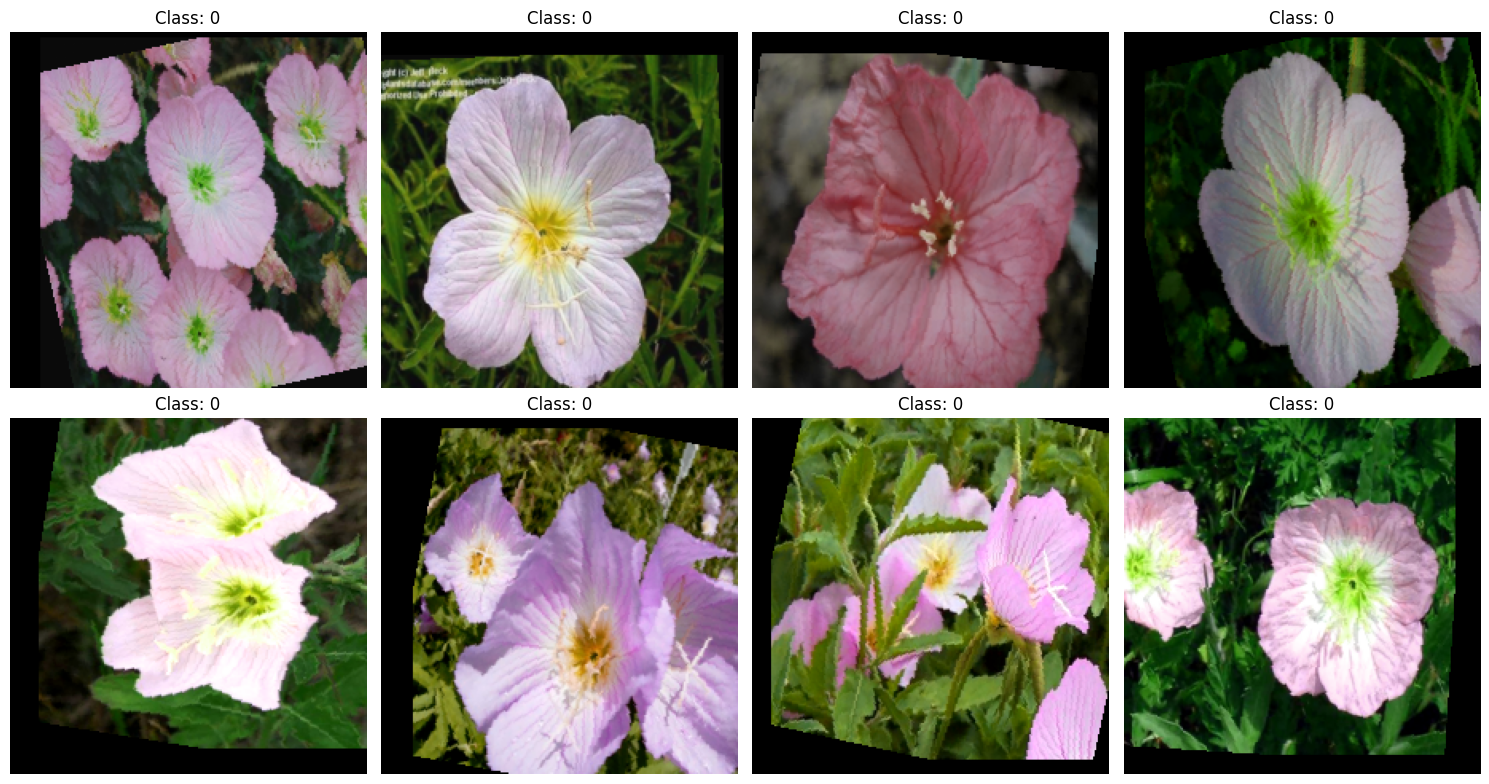

In [ ]:
# Visualize sample images
def visualize_samples(dataset, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(185, 8))
    axes = axes.ravel()
    
    for i in range(num_samples):
        img, label = dataset[i]
        
        # Denormalize for visualization
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        img = img * std[:, None, None] + mean[:, None, None]
        img = torch.clamp(img, 0, 1)
        
        axes[i].imshow(img.permute(1, 2, 0))
        axes[i].set_title(f'Class: {label}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('./results/sample_images.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_samples(train_dataset)

## MixUp Data Augmentation Implementation

In [4]:
def mixup_data(x, y, alpha=1.0):
    """Returns mixed inputs, pairs of targets, and lambda"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """MixUp loss function"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

class MixUpDataLoader:
    """DataLoader wrapper that applies MixUp augmentation"""
    def __init__(self, dataloader, alpha=1.0, use_mixup=True):
        self.dataloader = dataloader
        self.alpha = alpha
        self.use_mixup = use_mixup
    
    def __iter__(self):
        for batch in self.dataloader:
            if self.use_mixup:
                x, y = batch
                x, y_a, y_b, lam = mixup_data(x, y, self.alpha)
                yield x, y_a, y_b, lam
            else:
                yield batch
    
    def __len__(self):
        return len(self.dataloader)

## Model Architectures

In [5]:
class ModifiedResNet(nn.Module):
    """Modified ResNet with additional depth and reduced parameters"""
    def __init__(self, num_classes=102, pretrained=True):
        super(ModifiedResNet, self).__init__()
        # Use ResNet50 as base
        self.backbone = models.resnet50(pretrained=pretrained)
        
        # Remove the final classification layer
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        
        # Add custom classifier with dropout and batch norm
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        output = self.classifier(features)
        return output
    
    def get_features(self, x):
        """Extract features for triplet loss"""
        features = self.backbone(x)
        features = F.adaptive_avg_pool2d(features, (1, 1))
        features = features.view(features.size(0), -1)
        return features

class EfficientNetClassifier(nn.Module):
    """EfficientNet-based classifier"""
    def __init__(self, num_classes=102, pretrained=True):
        super(EfficientNetClassifier, self).__init__()
        # Use EfficientNet-B0
        self.backbone = models.efficientnet_b0(pretrained=pretrained)
        
        # Replace classifier
        num_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

def create_model(model_type='resnet', num_classes=102, pretrained=True):
    """Factory function to create models"""
    if model_type == 'resnet':
        return ModifiedResNet(num_classes, pretrained)
    elif model_type == 'efficientnet':
        return EfficientNetClassifier(num_classes, pretrained)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

## Triplet Loss Implementation

In [6]:
class TripletLoss(nn.Module):
    """Triplet loss implementation"""
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive)
        distance_negative = F.pairwise_distance(anchor, negative)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

class TripletDataset(torch.utils.data.Dataset):
    """Dataset for triplet loss training"""
    def __init__(self, dataset):
        self.dataset = dataset
        self.labels = [self.dataset[i][1] for i in range(len(self.dataset))]
        self.label_to_indices = {}
        
        # Group indices by label
        for idx, label in enumerate(self.labels):
            if label not in self.label_to_indices:
                self.label_to_indices[label] = []
            self.label_to_indices[label].append(idx)
    
    def __getitem__(self, index):
        anchor_img, anchor_label = self.dataset[index]
        
        # Select positive (same class)
        positive_indices = self.label_to_indices[anchor_label]
        positive_index = random.choice([idx for idx in positive_indices if idx != index])
        positive_img, _ = self.dataset[positive_index]
        
        # Select negative (different class)
        negative_label = random.choice([label for label in self.label_to_indices.keys() if label != anchor_label])
        negative_index = random.choice(self.label_to_indices[negative_label])
        negative_img, _ = self.dataset[negative_index]
        
        return anchor_img, positive_img, negative_img, anchor_label
    
    def __len__(self):
        return len(self.dataset)

## Training Functions

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs=20, use_mixup=False, mixup_alpha=1.0, save_path='./models/best_model.pth'):
    """Train model with optional MixUp augmentation"""
    model = model.to(device)
    best_val_acc = 0.0
    train_losses = []
    val_accuracies = []
    
    # Create MixUp dataloader if needed
    if use_mixup:
        mixup_loader = MixUpDataLoader(train_loader, alpha=mixup_alpha, use_mixup=True)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        if use_mixup:
            progress_bar = tqdm(mixup_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
            for inputs, targets_a, targets_b, lam in progress_bar:
                inputs = inputs.to(device)
                targets_a = targets_a.to(device)
                targets_b = targets_b.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})
        else:
            progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
            for inputs, targets in progress_bar:
                inputs, targets = inputs.to(device), targets.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
        
        val_acc = 100 * val_correct / val_total
        epoch_loss = running_loss / len(train_loader)
        
        train_losses.append(epoch_loss)
        val_accuracies.append(val_acc)
        
        print(f'Epoch {epoch+1}: Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, save_path)
        
        scheduler.step()
    
    return train_losses, val_accuracies, best_val_acc

def train_with_triplet_loss(model, train_dataset, val_loader, num_epochs=10):
    """Train model with triplet loss"""
    triplet_dataset = TripletDataset(train_dataset)
    triplet_loader = DataLoader(triplet_dataset, batch_size=16, shuffle=True, num_workers=4)
    
    triplet_criterion = TripletLoss(margin=0.2)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    model = model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        progress_bar = tqdm(triplet_loader, desc=f'Triplet Epoch {epoch+1}/{num_epochs}')
        for anchor, positive, negative, _ in progress_bar:
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            
            optimizer.zero_grad()
            
            # Get features
            anchor_features = model.get_features(anchor)
            positive_features = model.get_features(positive)
            negative_features = model.get_features(negative)
            
            loss = triplet_criterion(anchor_features, positive_features, negative_features)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            progress_bar.set_postfix({'Triplet Loss': f'{loss.item():.4f}'})
        
        print(f'Triplet Epoch {epoch+1}: Loss: {running_loss/len(triplet_loader):.4f}')
    
    return model

In [8]:
def evaluate_model(model, test_loader, model_name="Model"):
    """Evaluate model performance"""
    model.eval()
    all_predictions = []
    all_targets = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc='Evaluating'):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f'{model_name} Test Accuracy: {accuracy:.2f}%')
    
    return accuracy, all_predictions, all_targets

def plot_training_history(train_losses, val_accuracies, title="Training History"):
    """Plot training loss and validation accuracy"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    
    ax2.plot(val_accuracies)
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(f'./results/{title.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

## Few-Shot Learning Analysis

In [9]:
def create_few_shot_dataset(original_dataset, shots_per_class=[1, 3, 5]):
    """Create few-shot learning datasets"""
    few_shot_datasets = {}
    
    # Group samples by class
    class_samples = {}
    for idx, (_, label) in enumerate(original_dataset):
        if label not in class_samples:
            class_samples[label] = []
        class_samples[label].append(idx)
    
    for shots in shots_per_class:
        selected_indices = []
        for class_label, indices in class_samples.items():
            # Randomly select 'shots' samples per class
            selected = random.sample(indices, min(shots, len(indices)))
            selected_indices.extend(selected)
        
        few_shot_datasets[shots] = Subset(original_dataset, selected_indices)
        print(f"{shots}-shot dataset: {len(selected_indices)} samples")
    
    return few_shot_datasets

def analyze_few_shot_performance(model_type='resnet', shots_list=[1, 3, 5, 10]):
    """Analyze model performance with different numbers of training samples"""
    few_shot_datasets = create_few_shot_dataset(train_dataset, shots_list)
    results = {}
    
    for shots in shots_list:
        print(f"\n=== Training with {shots} shots per class ===")
        
        # Create data loader
        few_shot_loader = DataLoader(few_shot_datasets[shots], batch_size=16, shuffle=True, num_workers=2)
        
        # Create and train model
        model = create_model(model_type, num_classes=102, pretrained=True)
        model = model.to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        
        # Train for fewer epochs due to small dataset
        train_losses, val_accuracies, best_val_acc = train_model(
            model, few_shot_loader, val_loader, criterion, optimizer, scheduler,
            num_epochs=10, save_path=f'./models/few_shot_{shots}_model.pth'
        )
        
        # Evaluate
        test_acc, _, _ = evaluate_model(model, test_loader, f"{shots}-shot {model_type}")
        results[shots] = {'val_acc': best_val_acc, 'test_acc': test_acc}
    
    return results

## Experiment 1: Baseline Models

In [ ]:
print("=== Training Baseline ResNet Model ===")

# Create ResNet model
resnet_model = create_model('resnet', num_classes=102, pretrained=True)
resnet_model = resnet_model.to(device)

# Define training parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train model
resnet_losses, resnet_val_accs, resnet_best_acc = train_model(
    resnet_model, train_loader, val_loader, criterion, optimizer, scheduler,
    num_epochs=20, save_path='./models/resnet_baseline.pth'
)

# Plot training history
plot_training_history(resnet_losses, resnet_val_accs, "ResNet Baseline Training")

=== Training Baseline ResNet Model ===
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/yh/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:10<00:00, 9.86MB/s]
Epoch 1/20: 100%|██████████| 32/32 [03:28<00:00,  6.51s/it, Loss=4.6595]


In [ ]:
# Load best model and evaluate
checkpoint = torch.load('./models/resnet_baseline.pth')
resnet_model.load_state_dict(checkpoint['model_state_dict'])

resnet_test_acc, resnet_preds, resnet_targets = evaluate_model(
    resnet_model, test_loader, "ResNet Baseline"
)

## Experiment 2: MixUp Augmentation

In [ ]:
print("=== Training ResNet with MixUp Augmentation ===")

# Create ResNet model for MixUp
mixup_model = create_model('resnet', num_classes=102, pretrained=True)
mixup_model = mixup_model.to(device)

# Define training parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mixup_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train with MixUp
mixup_losses, mixup_val_accs, mixup_best_acc = train_model(
    mixup_model, train_loader, val_loader, criterion, optimizer, scheduler,
    num_epochs=20, use_mixup=True, mixup_alpha=1.0, save_path='./models/resnet_mixup.pth'
)

# Plot training history
plot_training_history(mixup_losses, mixup_val_accs, "ResNet MixUp Training")

# Load best model and evaluate
checkpoint = torch.load('./models/resnet_mixup.pth')
mixup_model.load_state_dict(checkpoint['model_state_dict'])

mixup_test_acc, mixup_preds, mixup_targets = evaluate_model(
    mixup_model, test_loader, "ResNet MixUp"
)

## Experiment 3: EfficientNet Architecture

In [ ]:
print("=== Training EfficientNet Model ===")

# Create EfficientNet model
efficientnet_model = create_model('efficientnet', num_classes=102, pretrained=True)
efficientnet_model = efficientnet_model.to(device)

# Define training parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train model
eff_losses, eff_val_accs, eff_best_acc = train_model(
    efficientnet_model, train_loader, val_loader, criterion, optimizer, scheduler,
    num_epochs=20, save_path='./models/efficientnet_baseline.pth'
)

# Plot training history
plot_training_history(eff_losses, eff_val_accs, "EfficientNet Training")

# Load best model and evaluate
checkpoint = torch.load('./models/efficientnet_baseline.pth')
efficientnet_model.load_state_dict(checkpoint['model_state_dict'])

eff_test_acc, eff_preds, eff_targets = evaluate_model(
    efficientnet_model, test_loader, "EfficientNet"
)

## Experiment 4: Triplet Loss Fine-tuning

In [ ]:
print("=== Fine-tuning ResNet with Triplet Loss ===")

# Load pre-trained model
triplet_model = create_model('resnet', num_classes=102, pretrained=True)
checkpoint = torch.load('./models/resnet_baseline.pth')
triplet_model.load_state_dict(checkpoint['model_state_dict'])

# Fine-tune with triplet loss
triplet_model = train_with_triplet_loss(triplet_model, train_dataset, val_loader, num_epochs=5)

# Save triplet model
torch.save(triplet_model.state_dict(), './models/resnet_triplet.pth')

# Evaluate triplet model
triplet_test_acc, triplet_preds, triplet_targets = evaluate_model(
    triplet_model, test_loader, "ResNet Triplet"
)

## Experiment 5: Few-Shot Learning Analysis

In [ ]:
print("=== Few-Shot Learning Analysis ===")

# Analyze few-shot performance
few_shot_results = analyze_few_shot_performance(model_type='resnet', shots_list=[1, 3, 5, 10])

# Plot few-shot results
shots = list(few_shot_results.keys())
val_accs = [few_shot_results[s]['val_acc'] for s in shots]
test_accs = [few_shot_results[s]['test_acc'] for s in shots]

plt.figure(figsize=(10, 6))
plt.plot(shots, val_accs, 'o-', label='Validation Accuracy', linewidth=2, markersize=8)
plt.plot(shots, test_accs, 's-', label='Test Accuracy', linewidth=2, markersize=8)
plt.xlabel('Shots per Class')
plt.ylabel('Accuracy (%)')
plt.title('Few-Shot Learning Performance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(shots)
plt.tight_layout()
plt.savefig('./results/few_shot_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print results table
print("\nFew-Shot Learning Results:")
print("Shots\tVal Acc\tTest Acc")
print("-" * 25)
for shots in [1, 3, 5, 10]:
    print(f"{shots}\t{few_shot_results[shots]['val_acc']:.2f}%\t{few_shot_results[shots]['test_acc']:.2f}%")

## Results Analysis and Visualization

In [ ]:
# Compare all models
model_results = {
    'ResNet Baseline': resnet_test_acc,
    'ResNet + MixUp': mixup_test_acc,
    'EfficientNet': eff_test_acc,
    'ResNet + Triplet': triplet_test_acc
}

# Plot comparison
plt.figure(figsize=(12, 8))
models = list(model_results.keys())
accuracies = list(model_results.values())
colors = ['skyblue', 'lightgreen', 'salmon', 'gold']

bars = plt.bar(models, accuracies, color=colors, alpha=0.8)
plt.xlabel('Model')
plt.ylabel('Test Accuracy (%)')
plt.title('Model Performance Comparison on Oxford Flowers 102')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('./results/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print results summary
print("\n=== FINAL RESULTS SUMMARY ===")
print("Model\t\t\tTest Accuracy")
print("-" * 40)
for model, acc in model_results.items():
    print(f"{model:<20}\t{acc:.2f}%")

best_model = max(model_results, key=model_results.get)
print(f"\nBest performing model: {best_model} ({model_results[best_model]:.2f}%)")

In [ ]:
# Generate confusion matrix for best model
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", top_k=20):
    """Plot confusion matrix for top-k classes"""
    # Get most frequent classes
    unique_labels, counts = np.unique(y_true, return_counts=True)
    top_classes = unique_labels[np.argsort(counts)[-top_k:]]
    
    # Filter predictions and targets for top classes
    mask = np.isin(y_true, top_classes)
    y_true_filtered = np.array(y_true)[mask]
    y_pred_filtered = np.array(y_pred)[mask]
    
    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=top_classes)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=top_classes, yticklabels=top_classes)
    plt.title(f'{title} (Top {top_k} Classes)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f'./results/{title.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot confusion matrix for best model
if best_model == 'ResNet Baseline':
    plot_confusion_matrix(resnet_targets, resnet_preds, "ResNet Baseline Confusion Matrix")
elif best_model == 'ResNet + MixUp':
    plot_confusion_matrix(mixup_targets, mixup_preds, "ResNet MixUp Confusion Matrix")
elif best_model == 'EfficientNet':
    plot_confusion_matrix(eff_targets, eff_preds, "EfficientNet Confusion Matrix")
elif best_model == 'ResNet + Triplet':
    plot_confusion_matrix(triplet_targets, triplet_preds, "ResNet Triplet Confusion Matrix")

## Feature Visualization with t-SNE

In [ ]:
def extract_features_and_visualize(model, dataloader, num_samples=1000):
    """Extract features and create t-SNE visualization"""
    model.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloader):
            if len(features) >= num_samples:
                break
                
            inputs = inputs.to(device)
            if hasattr(model, 'get_features'):
                batch_features = model.get_features(inputs)
            else:
                # For EfficientNet
                batch_features = model.backbone.features(inputs)
                batch_features = F.adaptive_avg_pool2d(batch_features, 1).flatten(1)
            
            features.append(batch_features.cpu().numpy())
            labels.append(targets.numpy())
    
    features = np.vstack(features)[:num_samples]
    labels = np.hstack(labels)[:num_samples]
    
    # Apply t-SNE
    print("Applying t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    features_2d = tsne.fit_transform(features)
    
    # Plot
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                         c=labels, cmap='tab20', alpha=0.6, s=2)
    plt.colorbar(scatter)
    plt.title('t-SNE Visualization of Learned Features')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.tight_layout()
    plt.savefig('./results/tsne_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize features from best model
if best_model == 'ResNet Baseline':
    extract_features_and_visualize(resnet_model, test_loader)
elif best_model == 'ResNet + MixUp':
    extract_features_and_visualize(mixup_model, test_loader)
elif best_model == 'EfficientNet':
    extract_features_and_visualize(efficientnet_model, test_loader)
elif best_model == 'ResNet + Triplet':
    extract_features_and_visualize(triplet_model, test_loader)

## Model Analysis and Statistics

In [ ]:
def count_parameters(model):
    """Count model parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Model statistics
print("=== MODEL STATISTICS ===")
print(f"ResNet Model Parameters: {count_parameters(resnet_model):,}")
print(f"EfficientNet Model Parameters: {count_parameters(efficientnet_model):,}")

# Performance per parameter efficiency
resnet_params = count_parameters(resnet_model)
eff_params = count_parameters(efficientnet_model)

print(f"\nResNet Accuracy/Parameter: {resnet_test_acc/resnet_params*1e6:.4f} (acc per million params)")
print(f"EfficientNet Accuracy/Parameter: {eff_test_acc/eff_params*1e6:.4f} (acc per million params)")

# Save final results to file
results_summary = f"""
Oxford Flowers 102 Classification Results
========================================

Dataset Statistics:
- Training samples: {len(train_dataset)}
- Validation samples: {len(val_dataset)}
- Test samples: {len(test_dataset)}
- Number of classes: 102

Model Performance:
- ResNet Baseline: {resnet_test_acc:.2f}%
- ResNet + MixUp: {mixup_test_acc:.2f}%
- EfficientNet: {eff_test_acc:.2f}%
- ResNet + Triplet: {triplet_test_acc:.2f}%

Best Model: {best_model} ({model_results[best_model]:.2f}%)

Few-Shot Learning Results:
"""

for shots in [1, 3, 5, 10]:
    results_summary += f"- {shots} shots: {few_shot_results[shots]['test_acc']:.2f}%\n"

results_summary += f"""

Model Complexity:
- ResNet Parameters: {resnet_params:,}
- EfficientNet Parameters: {eff_params:,}
"""

with open('./results/final_results.txt', 'w') as f:
    f.write(results_summary)

print("Results saved to ./results/final_results.txt")
print("\n=== EXPERIMENT COMPLETED ===")